# SpinGlassPlots

In [1]:
# imports
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
import itertools
import re


cwd = os.getcwd()

In [101]:
#load data
path = 'data'
files = glob.glob(path + '/*.csv')
data_frames = {}
for f in files:
    name = os.path.basename(f).replace('.csv', '')
    temp_df = pd.read_csv(f, sep=";")
    temp_df = temp_df.dropna(axis=1, how='all')
    # create new column with filename
    if temp_df["instance"].dtype == "object":
        temp_df["instance"] = temp_df["instance"].str.replace("_sg.txt", "").astype(int)

    temp_df['filename'] = name
    if name in ["CBFM-P_P4_dwave", "CBFM-P_P16_dwave"]:
        temp_df = temp_df.drop("Unnamed: 0", axis=1)
        temp_df.rename(columns = {'best_dwave':'energy'}, inplace = True)

    # add dataframe to dictionary
    data_frames[name] = temp_df
    print(f'Successfully created dataframe for {name} with shape {temp_df.shape}')

Successfully created dataframe for CBFM-P_P16_dwave with shape (100, 4)
Successfully created dataframe for CBFM-P_P16_sb_updated with shape (100, 7)
Successfully created dataframe for CBFM-P_P16_truncate2^12 with shape (80, 22)
Successfully created dataframe for CBFM-P_P16_truncate2^16 with shape (22, 22)
Successfully created dataframe for CBFM-P_P4_dwave with shape (100, 4)
Successfully created dataframe for CBFM-P_P4_truncate2^12 with shape (800, 22)
Successfully created dataframe for CBFM-P_P4_truncate2^16 with shape (800, 22)
Successfully created dataframe for CBFM-P_P4_truncate2^8 with shape (800, 22)
Successfully created dataframe for CBFM-P_P8_truncate2^12 with shape (800, 22)
Successfully created dataframe for CBFM-P_P8_truncate2^16 with shape (800, 22)
Successfully created dataframe for CBFM_P12_sb with shape (100, 6)
Successfully created dataframe for CBFM_P16_sb with shape (100, 6)
Successfully created dataframe for CBFM_P4_sb with shape (100, 6)
Successfully created datafra

In [116]:
class UniversalPlotter:
    def __init__(self, data: dict):
        self.data_frames = data

    def plot(self, tables, quantities):
        ...

    def plot_energies(self, *args, base="best", title = "energy comparison"):
        instance_list = []
        for table in args:
            instances = self.data_frames[table]["instance"].unique()
            instance_list.append(instances)
        instances = min(instance_list, key=len)

        table_energies = {}
        for table in args:
            energy = []
            for i in instances:
                df =  self.data_frames[table]
                best_energy = df[df["instance"] == i].energy.min()
                energy.append(best_energy)
            table_energies[table] = energy

        basis_energy = []
        if base == "best":
            for i in range(len(instances)):
                best_known = 0
                for table in args:
                    if table_energies[table][i] < best_known:
                        best_known = table_energies[table][i]
                basis_energy.append(best_known)
            label_name = r"E_{best}"

        elif base == "dwave":
            for table in args:
                x = re.search("dwave$", table)
                if x:
                    frame = table
                    break
            for i in range(len(instances)):
                basis_energy.append(table_energies[frame][i])
            label_name = r"E_{dwave}"

        fig, ax = plt.subplots()
        markers = itertools.cycle(('*', '+', '.', "x", "1", "2", "3", "4"))
        for table in args:
            energy = table_energies[table]
            energy = [(energy[i]-basis_energy[i])/abs(basis_energy[i]) for i in range(len(instances))]
            ax.scatter(np.arange(1,len(instances)+1,1), energy, label= self._name_to_legend(table), marker=next(markers))

        ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
        ax.set_xlabel('instance index')

        ax.set_yscale('symlog', linthresh=0.001, subs=list(range(1,11)))
        ax.set_ylim([-0.001, 0.1]) if base=="best" else ax.set_ylim([-0.01, 0.1])
        ax.set_ylabel(r'$\frac{(E - %s)}{|%s|}$' % (label_name, label_name), rotation="horizontal", fontsize=15)

        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_xticks(np.arange(0,len(instances)+1,10))
        ax.set_xticks(np.arange(0,len(instances)+1), minor=True)

        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-3, -3))
        ax.yaxis.set_major_formatter(formatter)
        ax.yaxis.set_label_coords(-0.15, 0.5)

        ax.set_title(title)
        ax.legend(ncols=2)
        #plt.grid(True)
        plt.savefig("plot.pdf", bbox_inches="tight")


    def available_tables(self):
        for frame in self.data_frames.keys():
            print(frame)

    def available_quantities(self):
        available = {}
        for name, df in self.data_frames.items():
            for column in df.columns:
                if column in available.keys():
                    available[column].append(name)
                else:
                    available[column] = [name]
        for quantity, tables in available.items():
            print(quantity + ": ", tables)

    @staticmethod
    def _name_to_legend(table_name: str):
        # TODO: write better
        dw = re.search("dwave", table_name)
        sb = re.search("sb", table_name)
        peps12 = re.search(r"tr2\^12", table_name)
        peps16 = re.search(r"tr2\^16", table_name)
        peps20 = re.search(r"tr2\^20", table_name)
        if dw:
            return "Dwave"
        elif sb:
            return "Simulated Bifurcation"
        elif peps12:
            return "Truncation 2^12"
        elif peps16:
            return "Truncation 2^16"
        elif peps20:
            return "Truncation 2^20"
        else:
            return table_name

In [117]:
plotter = UniversalPlotter(data_frames)
plotter.available_tables()
#plotter.available_quantities()

CBFM-P_P16_dwave
CBFM-P_P16_sb_updated
CBFM-P_P16_truncate2^12
CBFM-P_P16_truncate2^16
CBFM-P_P4_dwave
CBFM-P_P4_truncate2^12
CBFM-P_P4_truncate2^16
CBFM-P_P4_truncate2^8
CBFM-P_P8_truncate2^12
CBFM-P_P8_truncate2^16
CBFM_P12_sb
CBFM_P16_sb
CBFM_P4_sb
CBFM_P8_sb
P16_CBFM-P_tr2^12
P16_CBFM-P_tr2^16
P16_CBFM-P_tr2^20
RCO_Z3_truncate2^8_i1-5
RCO_Z4_truncate2^8
sb_P16
Z3_RCO_tr2^10
Z3_RCO_tr2^14


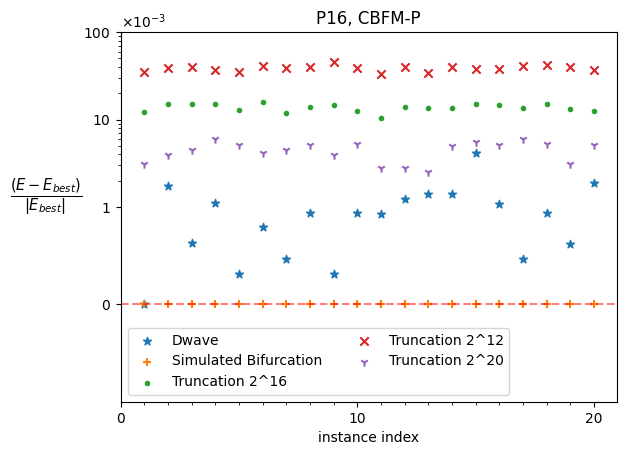

In [119]:
plotter.plot_energies("CBFM-P_P16_dwave", "CBFM-P_P16_sb_updated","P16_CBFM-P_tr2^16", "P16_CBFM-P_tr2^12", "P16_CBFM-P_tr2^20", title="P16, CBFM-P")